# Predicting Citation/Arrest when pulled over by police vehicle in Sacramento

We will try to predict if someone gets arested or recieves a citation, when pulled over. Some of features we want to use are already good to go for predicting, however, we will need to do one hot encoding on columns like Race and Gender. This is a classification problem; 0 or False is the label if someone does not recieve a citation or arrest when stopped by a police vehicle, 1 or True is the label if someone does recieve a citation or arrest when stopped by a police vehicle. We will model our data using the Random Forest and Gradient Boosting algorithms.

In [65]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import re

In [66]:
file = pd.read_csv("ml.csv")

## Splitting data training and test set

In [67]:
y = file['ResultCitation'] + file['ResultArrest'] 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
file.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))  else col for col in file.columns.values]
cols = [col for col in file.columns if col not in ['ResultCitation', 'ResultArrest', 'ResultReport', 'ResultAdvised', 'Citation', 'ResultFC', 'Year']]

X = file[cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



C:\Users\kushs\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [68]:
X_train.head(5)

,ExitVehicle,PassengerCount,SearchDriver,SearchPassenger,SearchVehicle,FSWeapons,FSDrugs,FSCash,FSVehicle,FSAlcohol,...,OfficerAbra_912,OfficerAbra_922,OfficerAbra_928,OfficerAbra_929,OfficerAbra_931,OfficerAbra_964,OfficerAbra_990,OfficerAbra_991,OfficerAbra_996,OfficerAbra_998
32081,False,2,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1723,False,1,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
13642,True,2,True,True,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3589,False,1,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
45922,False,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


## Feature Importances


As seen above, we have a lot of columns (2420) columns. Because this would be computationally intensive to run through a an ensemble or boosting classifier, and I don't have a lot of RAM on my computer, let's use the Decision Tree classifier to give us a list of feature importances.  The decisiontree classifier, albeit having high variance, is a good model in terms of interpretability because it is easy to understand how it makes it's decisions. In addition, it will not be as computationally intensive to run on all of our data.

In [69]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_test)

In [70]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_dtc)))
print('Precision Score : ' + str(precision_score(y_test,y_dtc)))
print('Recall Score : ' + str(recall_score(y_test,y_dtc)))
print('F1 Score : ' + str(f1_score(y_test,y_dtc)))

Accuracy Score : 0.8228296464612711
Precision Score : 0.7701906412478337
Recall Score : 0.7703241462991853
F1 Score : 0.7702573879885605


In [46]:
feature_importances = pd.DataFrame(dtc.feature_importances_, index = X_train.columns, columns=['importance'])

In [47]:
bar = feature_importances.sort_values('importance', ascending=False)[:9]
bar

,importance
ConsentRequested_FALSE,0.192409
DetentionDuration,0.104379
StopCause_REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,0.089978
Age,0.051570
FSNothing,0.050308
StopHour,0.031066
EntryHour,0.027749
StopDayofMonth,0.025510
EntryDayofMonth,0.024442


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

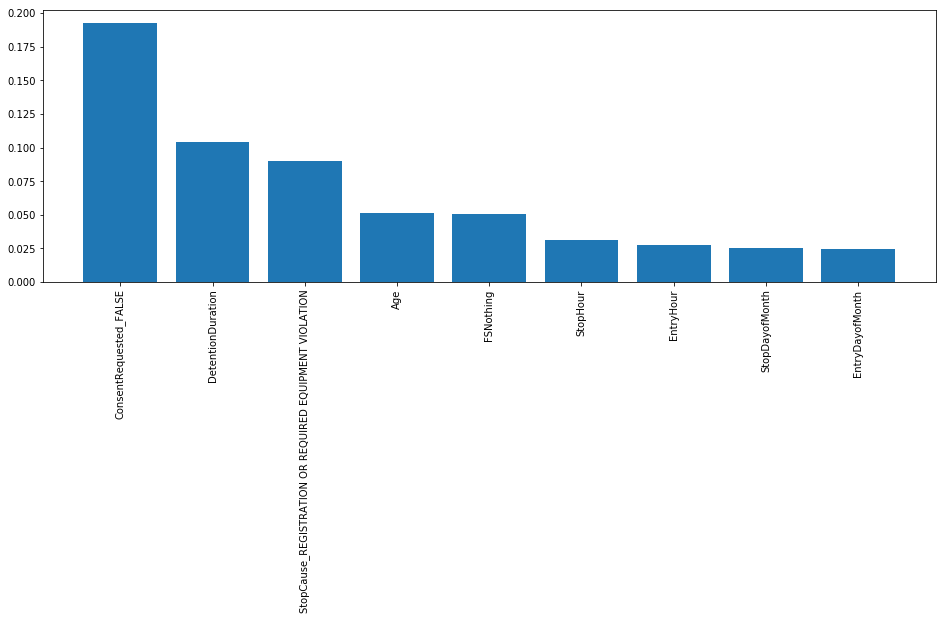

In [52]:
plt.figure(figsize=(16, 5))
plt.bar(bar.index.values, bar['importance'])
plt.xticks(rotation=90)


Above are the top nine feature importances according to the decision tree classifier.  To speed up our models let's use the top 200 features found for each model.

In [71]:
top_features = feature_importances.sort_values('importance', ascending=False).index.values[:200]

top_features = top_features.astype(str)

X_train = X_train[top_features]
X_test = X_test[top_features]

## Modeling

For this task we will use both the Random Forest Classifier and Gradient Boosting Classifier to make predictions about citations and arrest. We will use a randomized grid search for the Random Forest Classifier that produce the best fit for our model

In [74]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [75]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [76]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 20, cv = 2, verbose=2, n_jobs = -1)
rf_random.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.3min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 180,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [78]:
clf = RandomForestClassifier(n_estimators= 180, min_samples_split= 10, min_samples_leaf=2, max_features='sqrt', max_depth=110, bootstrap=False)

In [79]:
print(file.columns.values)

['Citation' 'ExitVehicle' 'PassengerCount' ... 'OfficerAbra_991'
 'OfficerAbra_996' 'OfficerAbra_998']


In [80]:
y_pred = rf_random.predict(X_test)

# Random Forest Accuracy

In [81]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

Accuracy Score : 0.8724854641448907
Precision Score : 0.8277032761840095
Recall Score : 0.8452071416189981
F1 Score : 0.8363636363636364


# Gradient Boosting Accuracy 

In [84]:
xgb = XGBClassifier(n_estimators = 1000)
xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)

In [85]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_xgb)))
print('Precision Score : ' + str(precision_score(y_test,y_xgb)))
print('Recall Score : ' + str(recall_score(y_test,y_xgb)))
print('F1 Score : ' + str(f1_score(y_test,y_xgb)))

Accuracy Score : 0.8785671322595736
Precision Score : 0.8179916317991632
Recall Score : 0.8810885768764084
F1 Score : 0.8483685220729367


# Conclusion

We can see that Random Forest and XGBoost performed fairly well on our data, achieving pretty reasonable accuracy. In future iterations of this project, I might try to use stacking/blending of different models to achieve a better accuracy, using data preprocessing like normalization to allow our data to be used by other models (Trees are algorithms that are invariant to data normalization).